In [323]:
import warnings, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

import numpy as np, pandas as pd
from datetime import datetime
import time
import sys
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from nbeats_model import NBeatsNet as NBeatsNet
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from utils import TSMinMaxScaler, DailyAggregator, generate_sine_data, MinMaxScaler_Feat_Dim

# Load Data

In [347]:
data_dir = './data/'
dataset = 'energy'            # sine, stocks, energy
perc = 5                    # 5, 10, 20, 100
train_on = 'generated_data'         # 'real_data', 'generated_data'
vae_type = 'convI'

input_file = f'{dataset}_subsampled_train_perc_{perc}.npy'

data = np.load(data_dir + input_file)

N, T, D = data.shape   
print('data shape:', N, T, D) 

data shape: 913 24 28


# Some variables

In [348]:
backcast_length=20
forecast_length=4
seq_len = backcast_length + forecast_length

input_dim = output_dim = D
scaler_upper_bound = 5.
scaler_lower_bound = -5.

# Train Validation Split In Samples On True Data

In [349]:
valid_perc = 0.1

N_train = int(N * (1 - valid_perc))
N_valid = N - N_train

# Shuffle data
np.random.shuffle(data)

true_train_data = data[:N_train]
true_valid_data = data[N_train:]

print(true_train_data.shape, true_valid_data.shape )

(821, 24, 28) (92, 24, 28)


# Read synthetic data as dataframe

In [350]:
#syn_train_data = true_train_data

In [351]:
if train_on == 'real_data':
    syn_train_data = true_train_data
else: 
    fname = f'vae_{vae_type}_generated_{dataset}_subsampled_train_perc_{perc}.npy'
    syn_train_data = np.load(data_dir + fname)
print(syn_train_data.shape)

(821, 24, 28)


# Define model train and validation sets

In [352]:
train_data = syn_train_data
valid_data = true_valid_data

print(train_data.shape,  valid_data.shape)

(821, 24, 28) (92, 24, 28)


# Preprocess synthetic data

### Add reversed series for training

In [353]:
train_data = np.concatenate([train_data, np.flip(train_data, axis=1)], axis=0)
train_data.shape

(1642, 24, 28)

# Min Max Scale Training and Validation Data

In [354]:
train_data_scaler = TSMinMaxScaler(
    scaling_len = backcast_length,
    input_dim = input_dim,
    upper_bound = scaler_upper_bound,
    lower_bound = scaler_lower_bound
)
scaled_train_data = train_data_scaler.fit_transform(train_data)


valid_data_scaler = TSMinMaxScaler(
    scaling_len = backcast_length,
    input_dim = input_dim,
    upper_bound = scaler_upper_bound,
    lower_bound = scaler_lower_bound
)
scaled_valid_data = valid_data_scaler.fit_transform(valid_data)

print(scaled_train_data.shape, scaled_valid_data.shape)

(1642, 24, 28) (92, 24, 28)


In [355]:
scaled_train_data.mean(), scaled_valid_data.mean()

(0.49863427288870155, 0.4628705731314827)

# X / Y Split

In [356]:
x_train, y_train = scaled_train_data[:, :backcast_length], scaled_train_data[:, backcast_length:]
x_valid, y_valid = scaled_valid_data[:, :backcast_length], scaled_valid_data[:, backcast_length:]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(1642, 20, 28) (1642, 4, 28) (92, 20, 28) (92, 4, 28)


In [357]:
print(x_train.mean(), y_train.mean(), x_valid.mean(), y_valid.mean())

0.49748156603786436 0.5043978071428888 0.4631576649613241 0.4614351139822757


# Nbeats

In [358]:
start = time.time() 

models = []
for d in range(D):
    
    print(f'-----------dim: {d}----------------')
    
    X, Y = x_train[:, :, d: d +1].copy(), y_train[:, :, d: d +1].copy()
    # X, Y = x_valid[:, :, d: d +1].copy(), y_valid[:, :, d: d +1].copy()

    model = NBeatsNet(
            input_dim=1,
            backcast_length=backcast_length, 
            forecast_length=forecast_length,
            stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
            nb_blocks_per_stack=3, 
            thetas_dim=(36, 36), 
            share_weights_in_stack=False,
            hidden_layer_units=50
        )

    model.compile(loss='mse', optimizer='adam')
    
    
    logpath = "./log/"
    logname = f'Log_nBeats_{dataset}_dim_{d}.txt'
    logfile = os.path.join(logpath, logname)
    csv_logger = CSVLogger(logfile, append=True)
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
    early = EarlyStopping(monitor='val_loss', mode='min', patience=10) # prevent overfitting

    mdpath = "./model/"
    mdname = f'nBeats_{dataset}_dim_{d}.h5'
    mdfile = os.path.join(mdpath, mdname)

    ckpt = ModelCheckpoint(mdfile, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #save whole model
    callbacks_list = [ckpt, early, csv_logger, reduceLR]
    callbacks_list = [ckpt, early, csv_logger, reduceLR]
    

    # Train the model.
    print('Training...')

    model.fit(X, 
              Y, 
              validation_split=0.2, 
              batch_size=64, 
              shuffle=True, 
              epochs=20, 
              callbacks=callbacks_list,
              verbose = 0
             )
    
    models.append(model )

end = time.time()
train_time = np.round((end - start)/60.0, 2)
print(f"Total training time: {train_time} minutes") 

-----------dim: 0----------------
Training...

Epoch 00001: val_loss improved from inf to 0.19335, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00002: val_loss improved from 0.19335 to 0.16305, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00003: val_loss improved from 0.16305 to 0.14561, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00004: val_loss improved from 0.14561 to 0.12703, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00005: val_loss did not improve from 0.12703

Epoch 00006: val_loss improved from 0.12703 to 0.12451, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00007: val_loss did not improve from 0.12451

Epoch 00008: val_loss did not improve from 0.12451

Epoch 00009: val_loss did not improve from 0.12451

Epoch 00010: val_loss did not improve from 0.12451

Epoch 00011: val_loss improved from 0.12451 to 0.12347, saving model to ./model\nBeats_energy_dim_0.h5

Epoch 00012: val_loss did not improve from 0.12347

Epoch 00013: val_loss

# Predictions

In [359]:
preds = []

for d in range(D):
    X, Y = x_valid[:, :, d: d +1].copy(), y_valid[:, :, d: d +1].copy()

    # Predict on the testing set (forecast).
    Yhat = models[d].predict(X)
    preds.append(Yhat)


Yhat = np.concatenate(preds, axis=-1)
print("the prediction_forecast shape is:", Yhat.shape) #shape: (30, 5, 1)

X = x_valid
Y = y_valid

the prediction_forecast shape is: (92, 4, 28)


In [360]:
Y.mean(), Yhat.mean()

(0.4614351139822757, 0.45627812)

In [361]:
mse = mean_squared_error(Y.flatten(), Yhat.flatten())
mae = mean_absolute_error(Y.flatten(), Yhat.flatten())
r_sq = r2_score(Y.flatten(), Yhat.flatten())

print('mse', mse)
print('mae', mae)
print('r_sq', r_sq)

mse 0.31974616488064644
mae 0.2717233090193697
r_sq 0.39457418132069344


In [362]:
generator = f'vae_{vae_type}' if train_on == f'generated_data' else 'None'

perf_metrics = [ [
            dataset,
            generator,
            perc,
            'nbeats', 
            train_on,
            np.round(mse, 3), 
            np.round(np.sqrt(mse), 3),
            np.round(mae, 3),
            np.round(r_sq, 3),   
            datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
            np.round(train_time, 3),
             ]
]

columns=[
    'Dataset_Name',
    'Generator_Type',
    'Perc_of_train_hist_len',
    'Forecast_algo',
    'Trained_on',
    'MSE',
    'RMSE',
    'MAE',
    'R-squared',
    'Time_Ran',
    'Train_time_minutes',
]
# convert to dataframe
perf_metrics = pd.DataFrame(perf_metrics, columns=columns)  

f_name = f'Results_{dataset}_traindata_perc{perc}_forecaster_nbeats_gen_trained_on_{generator}.csv'
perf_metrics.to_csv(f"./outputs/{f_name}", index=False)


perf_metrics

,Dataset_Name,Generator_Type,Perc_of_train_hist_len,Forecast_algo,Trained_on,MSE,RMSE,MAE,R-squared,Time_Ran,Train_time_minutes
0,energy,vae_convI,5,nbeats,generated_data,0.32,0.565,0.272,0.395,"08/22/2021, 21:35:27",2.38


# Plot

In [363]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


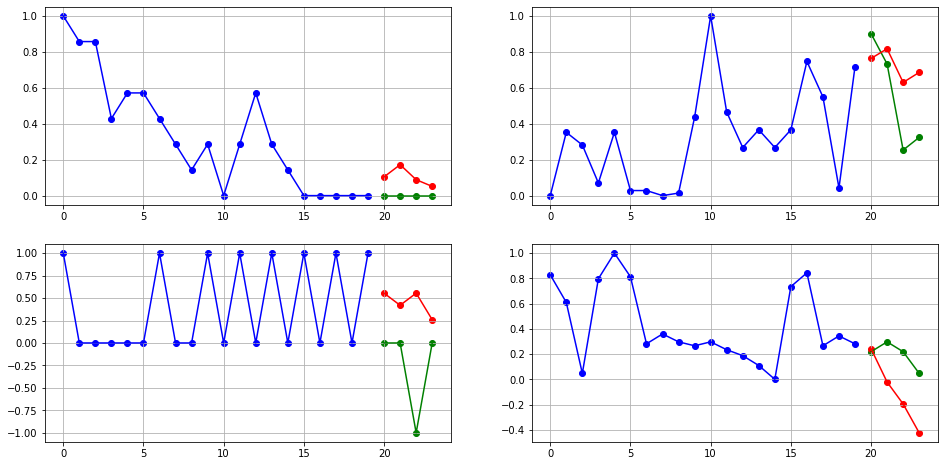

In [364]:
subplots = [221, 222, 223, 224]
plt.figure(1, figsize=(16,8))
norm_constant = 1
dim = 0

temp_y = Y.copy()
temp_yhat = Yhat.copy()
temp_x = X.copy()

for plot_id, i in enumerate(np.random.choice(range(len(X)), size=4, replace=False)):
    p1 = np.expand_dims(Yhat[i][:,dim], axis=-1)
    x1 = np.expand_dims(X[i][:,dim], axis=-1)
    y1 = np.expand_dims(Y[i][:,dim], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.savefig("nbeats-predictions-sines.png", dpi=300)
plt.show()